In [1]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.7/942.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━

In [102]:
import sagemaker
import boto3
import json
import pprint as pp
import os
import shutil
import csv
import time
import pprint
import io
import base64
import uuid
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import fiftyone as fo
import fiftyone.zoo as foz

## Load the Dataset

In [8]:
# includes all the available classes in the dataset 
classes = fo.utils.openimages.get_classes()

fo.config.dataset_zoo_dir = "./data/" # set the location for the dataset download

In [20]:
# preselect some classes as desired
# fiftyone downloads classes and hierarchy metadata but for our use case we will not be needing them.
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="validation",
    label_types=["points"],
    classes = ["Baseball bat", "car","Rugby ball","Lion","Musical instrument"],
    max_samples=200, # limit to 100 samples but can be increased as desired 
)

Ignoring invalid classes ['car']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
Only found 196 (<200) samples matching your requirements
 100% |███████████████████| 196/196 [9.8s elapsed, 0s remaining, 17.9 files/s]       
Dataset info written to './data/open-images-v7/info.json'
Loading 'open-images-v7' split 'validation'
Ignoring invalid classes ['car']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
 100% |█████████████████| 196/196 [13.4s elapsed, 0s remaining, 16.2 samples/s]      
Dataset 'open-images-v7-validation-200' created


In [29]:
# helper functions for generating metadata and creating some previews

def display_image(path):
    im = Image.open(path)
    plt.imshow(im)
    plt.figure(figsize=(10, 10))
    plt.show()

## Fabricate dataset using Titan 

In [231]:
# create a series images using titan image generator to augment the dataset with our fabricated images 
# we will leave a set for testing and search purposes later. 
# amazon.titan-image-generator-v1
boto3_bedrock = boto3.client('bedrock-runtime')

def generate_image(p, seed=1, number_of_images=5):
    # Create payload
    body = json.dumps(
        {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": p["prompt"],                    # Required
                "negativeText": p["neg_prompt"]   # Optional
            },
            "imageGenerationConfig": {
                "numberOfImages": number_of_images,   # Range: 1 to 5 
                "quality": "standard",  # Options: standard or premium
                "height": 512,        # Supported height list in the docs 
                "width": 512,         # Supported width list in the docs
                "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
                "seed": seed             # Range: 0 to 214783647
            }
        }
    )
    # Make model request
    response = boto3_bedrock.invoke_model(
        body=body,
        modelId="amazon.titan-image-generator-v1",
        accept="application/json", 
        contentType="application/json"
    )
    # Process the image payload
    response_body = json.loads(response.get("body").read())
    # img1_b64 = response_body["images"][0] # in bytes IO
    images_b64 = response_body["images"]
    images = []
    
    # save to disk 
    os.makedirs("./data/titan", exist_ok=True)

    for img_b64 in images_b64:
        # Decode + save
        filename = uuid.uuid4()
        img = Image.open(
            io.BytesIO(
                base64.decodebytes(
                    bytes(img_b64, "utf-8")
                )
            )
        )
        img.save("data/titan/{0}.png".format(filename))
        images.append(img)
    
    return images


def generate_image_prompts(messages, max_tokens,top_p,temp):

    model_id = "anthropic.claude-3-haiku-20240307-v1:0" # calling haiku 
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = boto3_bedrock.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    response_text = response_body["content"][0]["text"]    

    return response_text


In [209]:
# first let us create a series of prompts and negative prompts using Bedrock Claude 
prompt = """
You are an image prompt generator. Based on the specified comma separated list of topics in the <topics> xml tags, generate a set of text prompts that can be used to generate images using a text to image generative model. 
Each prompt should only be about one topic. 
Make necessary determination on related subjects and themes based on the topic and be creative with the generated prompts. 
The output should contain a list of prompts as well as corresponding negative prompts as outlined in the <example_output> xml tags. 
Generate 20 prompts

<topics>{topic}</topics>

The generated prompts will be directly passed to an text to image model so ensure the prompts contain enough details and creative descriptions. 

Output the data as well formed json array only as outlined in the <example_output> XML tags without any newline characters in the output

<example_output> 
[
    { "prompt":"person playing baseball swinging bat to score a home run", "neg_prompt"="well formed faces" },
    { "prompt":"person playing baseball at a packed stadium with cheering fans", "neg_prompt"="well formed faces" },
    { "prompt":"baseball player sliding to make a home run, electric atmosphere", "neg_prompt"="do not include baseball bats" },
]
</example_output> 

output: 

[

"""


In [210]:
image_prompts = []
request_payload = [
        { "role": "user",
          "content": [
              {"type": "text","text": prompt.replace("{topic}","baseball, savannah, lion")}
          ]
        }
    ]
response = generate_image_prompts(messages=request_payload,max_tokens=4096,temp=0.5,top_p=0.9) 
image_prompts = json.loads(response)

In [214]:
# lets review the prompts that we have prepared 
pprint.pp(image_prompts)

[{'prompt': 'baseball player hitting a grand slam home run in a packed stadium '
            'with cheering fans',
  'neg_prompt': 'blurry, low quality, distorted'},
 {'prompt': 'baseball team celebrating a championship win on the field with '
            'their trophy',
  'neg_prompt': 'low resolution, out of focus'},
 {'prompt': "close-up of a baseball player's intense expression as they wind "
            'up to pitch the ball',
  'neg_prompt': 'cartoon, stylized'},
 {'prompt': 'baseball umpire making a close call at home plate, players '
            'arguing in the background',
  'neg_prompt': '3D render, computer generated'},
 {'prompt': 'aerial view of a baseball diamond at sunset, players running the '
            'bases',
  'neg_prompt': 'grainy, pixelated'},
 {'prompt': 'savannah landscape with tall grass, acacia trees, and a herd of '
            'grazing zebras',
  'neg_prompt': 'low detail, flat colors'},
 {'prompt': 'close-up portrait of a majestic lion with a full mane, f

In [232]:
# Generate series of images using the prompts prepared, we are going to create 5 images per prompt
# approx 30 seconds per set of 5 images - approx 10 mins 

from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(5)

start_time = time.time()
results = pool.map(generate_image, image_prompts)
duration = time.time() - start_time
print(f"Processed {len(image_prompts)} in {duration} seconds")



Processed 20 in 126.72492980957031 seconds


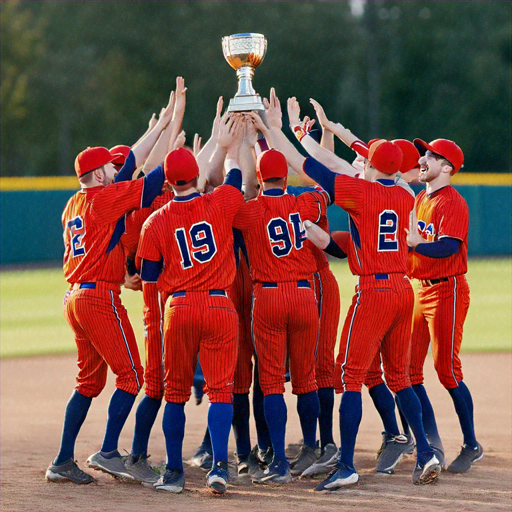

In [241]:
# display a sample image from the fabricated set
results[randrange(0,20)][randrange(0,4)]

## prepare a curated dataset of open image and fabricated images 

In [244]:
# move all images into curated folder 
os.makedirs("data/curated-images", exist_ok=True)

!cp -a ./data/open-images-v7/validation/data/. ./data/curated-images/
!cp -a ./data/titan/. ./data/curated-images/


In [245]:
# load all the images into a single dataset

sample_images = []
images_dir = "./data/curated-images"

for filename in os.listdir(images_dir):
    f = os.path.join(images_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
        sample_images.append(
            {
                'image_id':filename,
                'path':f,
                'title':'',
                'description':'',
                'tags':[],
                'keywords':[],
                'embeddings':[]
            }
        )

df_images = pd.DataFrame(sample_images)

df_images.head()

,image_id,path,title,description,tags,keywords,embeddings
0,00c73a28068f9b33.jpg,./data/curated-images/00c73a28068f9b33.jpg,,,[],[],[]
1,00a7655d4eabf186.jpg,./data/curated-images/00a7655d4eabf186.jpg,,,[],[],[]
2,039928928a45ca04.jpg,./data/curated-images/039928928a45ca04.jpg,,,[],[],[]
3,07080581c9f69bf9.jpg,./data/curated-images/07080581c9f69bf9.jpg,,,[],[],[]
4,0a1a999ef52a93f2.jpg,./data/curated-images/0a1a999ef52a93f2.jpg,,,[],[],[]


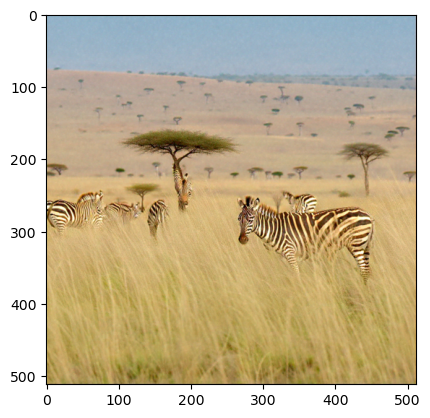

<Figure size 1000x1000 with 0 Axes>

In [246]:
test_image_path = df_images.sample()["path"].values[0]
display_image(test_image_path)

In [229]:
fabricated_images = []

In [247]:
# save for use in next notebook 
%store df_images

Stored 'df_images' (DataFrame)


In [ ]:
# uncomment below line to delete the dataset
#foz.delete_zoo_dataset("open-images-v7", split="validation")